# Simulacion - 75.26
## TP1 - Xorshift RNGs
### Grupo 4 
### Integrantes: Joaquín Rivero, Juan Pablo Aschieri, Diego Civini, Francisco Rovira Rossel

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi, e, log
from scipy.stats import kstest, shapiro

## Ejercicio 1

Hacemos una clase `Xorshift_generator` que dada una semilla devuelve un generador de numeros aleatorios de 32 bits realizando operaciones logicas de shifteo y xor. Los valores usados para la cantidad de shifteos fueron sacados del paper.

In [46]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [47]:
class Uniform_generator:
    def __init__(self, seed):
        self.xorshift_genertor = Xorshift_generator(seed)

    def rand(self):
        return self.xorshift_genertor.rand() / ((2**32)-1)
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Obtenemos un generador con una semilla y obtenemos 100000 numeros para analizar los resultados.

Graficamos los numeros en un histograma para obtener una representacion visual aproximada de su distribucion. Como buscamos numeros aleatorios entre 0 y 2^32 -1 deberia ser un grafico similar a una dist uniforme ente 0 y 2^32 -1

In [48]:
generator = Xorshift_generator(123456789)

In [49]:
def get_random_and_plot(generator, amount, bins):

    rand_numbers = generator.get_n_rand(amount)

    plt.hist(rand_numbers, bins = bins)
    plt.show()
    return rand_numbers

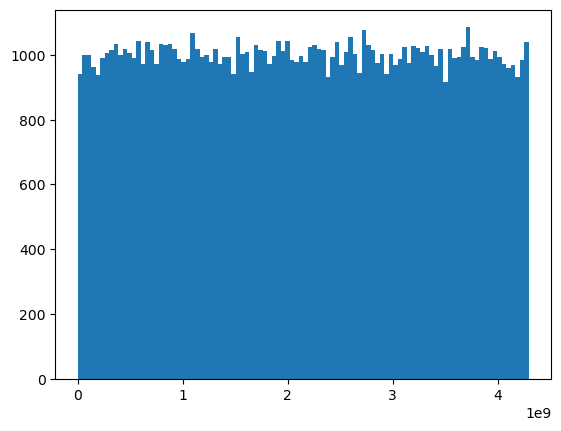

In [50]:
rand_numbers = get_random_and_plot(generator, 100000, 100)

Si bien no es perfecto se puede ver como aproximadamente los distintos box tienen la misma cantidad de ocurrencias, haciendo que el grafico dado se paresca a una meseta, que es el grafico que deberia tener una uniforme.

Si queremos obtener numero aleatorios entre 0 y 1 utilizando el xorshift generator, basta con generar un numero aleatorio de la misma manera y luego normalizarlo. Para ello dividimos al numero por el mayor valor posible, 2^32 -1. De esta manera obtenemos un numero aleatorio entre 0 y 1 con el nuevo generador uniform_generator

In [51]:
generator_u = Uniform_generator(5568782738)

De la misma forma graficamos un histograma para ver si la distribucion de los numeros se asemeja a una distribucion uniforme entre 0 y 1.

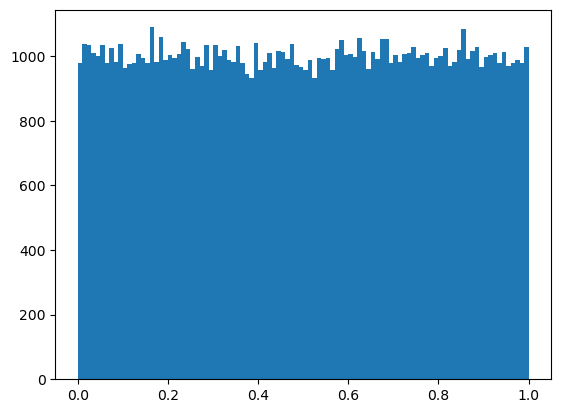

In [52]:
rand_numbers = get_random_and_plot(generator_u, 100000, 100)

De una forma similar, podemos ver a esta distribucion uniforme "de a pares", es decir, podemos graficar en el plano XY pares de números aleatorios generados.

In [53]:
pairs_of_rand_numbers_normalized = []
for i in range(50000):
    pairs_of_rand_numbers_normalized.append((generator_u.rand(), generator_u.rand()))

Ya obtenido el arreglo con las tuplas de numeros aleatorios, procedemos a graficarlos en un plano cartesiano. Si los números siguen una distribuicion uniforme entre 0 y 1, deberíamos ver que el gráfico se asemeja a un cuadrado de lado 1 cuyos vertices son (0,0), (0,1), (1,0), (1,1).

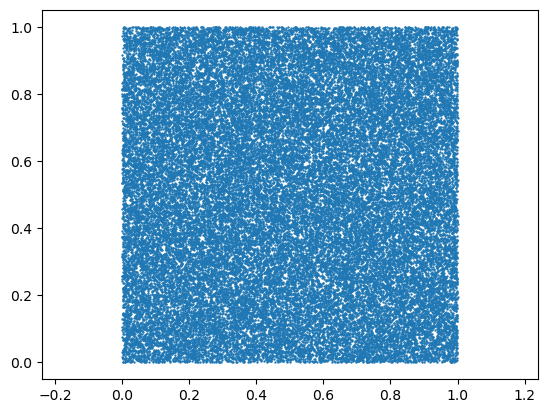

In [54]:
x = [p[0] for p in pairs_of_rand_numbers_normalized]
y = [p[1] for p in pairs_of_rand_numbers_normalized]
plt.scatter(x, y, s=0.5)
plt.axis('equal')
plt.show()

Visualmente se puede ver que, efectivamente, los puntos en conjunto forman un cuadrado y estan distribuidos uniformente sobre el grafico, lo cual tiene sentido ya que las coordenadas X e Y son independientes, entonces al tener una muestra de un tamaño considerable de tuplas de números aleatorios entre 0 y 1 (en este caso 50 mil tuplas), estos tienden a rellenar un cuadrado de lado 1. 

## Ejercicio 2

enunciado

### Test chi2


Si bien el test de la chi2 necesita que la distribución sea discreta, nosotros tenemos una distribución continua y uniforme. Esto presenta un problema. Para poder realizar este test, podemos discretizar la distribucion juntando valores de intervalos en bins. En este caso vamos a usar 100 bins.

Este test nos permite saber con un nivel de significación alfa (usaremos 0.05) si los valores que generamos NO tienen distribución uniforme. Para ello tomamos como hipótesis nula que la distribucion **es** uniforme en el intervalo correspondiente.  
Si podemos rechazar la hipotesis nula: afirmaremos que la distribución no es uniforme.  
En caso de no rechazar la hipótesis nula: no podemos afirmar que la distribución es uniforme.

Asumo h0 como que la dist es uniforme. Este test NO SIRVE para decir si una dist es uniforme. Sirve para decir, si se rechaza h0 puedo decir con un nivel de significacion alfa que la dist no es uniforme. Si no se rechaza H0 entonce NO ES QUE ES UNIFORME, si no que PUEDE ser uniforme.

In [55]:
from scipy.stats import chi2

In [56]:
def get_frequency(rand_numbers, bins, max):
    frequency = [0 for i in range(bins)]
    bin_size = max/bins

    for i in rand_numbers:
        j = 0
        seguir = True
        while seguir:
            if i < bin_size:
                frequency[j] += 1
                seguir = False
            else:
                j += 1
                i -= bin_size

    return frequency

In [57]:
def test_chi2_for_uniform_distribution(rand_numbers, bins, max, significance_level):
    frequency = get_frequency(rand_numbers, bins, max)

    expected_frecuency = len(rand_numbers)/bins
    aux = 0
    for i in frequency:
        aux += (i - expected_frecuency)**2
    d2 = aux/expected_frecuency

    upper_limit = chi2.ppf(1 - significance_level, df=bins-1)

    print(f"D2: {d2}")
    print(f"Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: {upper_limit}")
    if d2 > upper_limit:
        print("Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05")
    else:
        print("No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme")

Creamos un xorshift generator y le aplicamos el test de la chi2 para tanto el generador de numeros entre 0 y 2^32-1 y el de numeros entre 0 y 1, probando generar 100, 10000 y 100000 numeros.

In [58]:
generator = Xorshift_generator(565555555)

#### Pruebas para generador

Probamos el generador con una muestra de 100 numeros

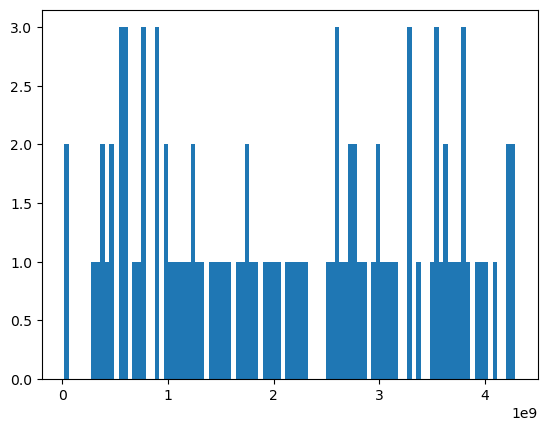

In [59]:
rand_numbers  = get_random_and_plot(generator, 100, 100)


In [60]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 64.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Esto se debe a que no hay grandes diferencias entre los distintos bins. Como se mostro en el grafico anterior.

Sin embargo esto depende enteramente de la suerte que tengamos al generar la muestra, ya que a pesar de que sea poco probable, se podria dar el caso de que los 100 numeros estan en el mismo bin. Por ejemplo en el siguiente caso

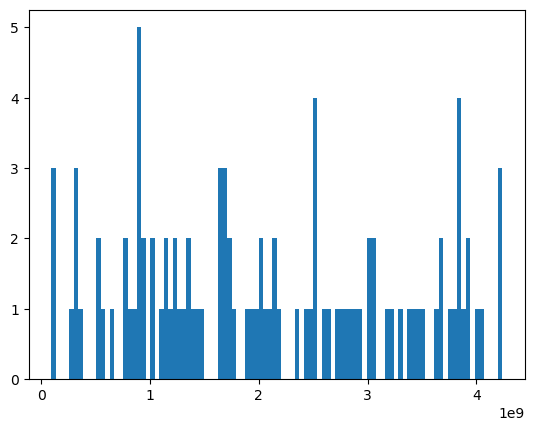

In [61]:
#dejamos pasar 100 numeros de la semilla
for i in range(300):
    generator.rand()

rand_numbers  = get_random_and_plot(generator, 100, 100)



In [62]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 132.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05


En este caso vemos que se rechaza h0, es decir que podemos asegurar bajo un nivel de significancia 0.05 que la distribucion no es de tipo uniforme. Sin embargo esto se debe a que tuvimos "mala suerte" a la hora de obtener los numeros. Lo que se ve en el anterior grafico que contiene muchas mas irregularidades que el anterior

Para evitar que nuestros resultados esten muy influenciados por la "suerte" que tengamos al obtener numeros, los generamos en magnitudes mas grandes, esto hara que sea mucho menos probable que el test de que se rechaza la hipotesis nula por "mala suerte."

Probamos el generador con una muestra de 10000 numeros

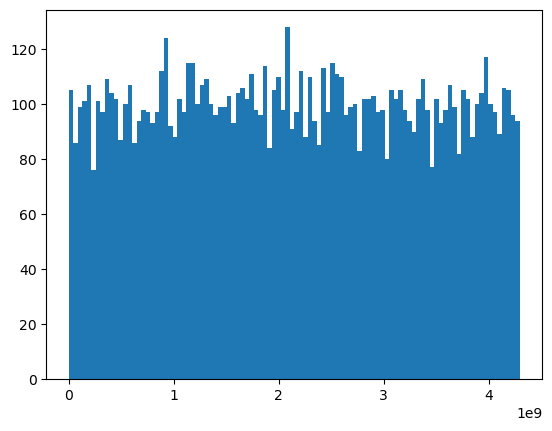

In [63]:
rand_numbers  = get_random_and_plot(generator, 10000, 100)

In [64]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 92.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

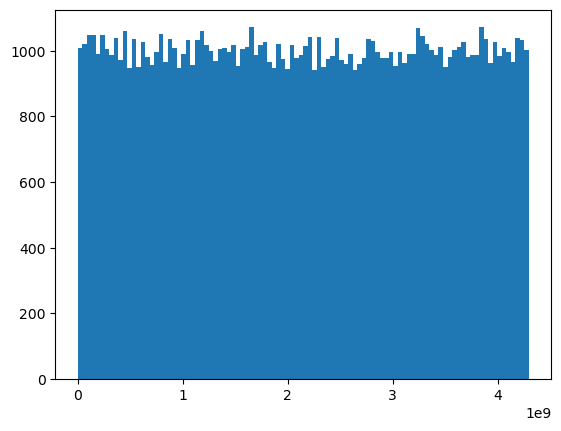

In [65]:
rand_numbers  = get_random_and_plot(generator, 100000, 100)

In [66]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 111.282
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


#### Pruebas para generador normalizado

A partir de aquí, se prueba el generador para numeros randoms entre 0 y 1, para 100, 10000 y 100000 numeros. Es muy similar a lo obtenido en el caso anterior ya que para generat numeros entre 0 y 1 se utiliza el generador testeado anteriormente.

In [67]:
generator_u = Uniform_generator(653678946)

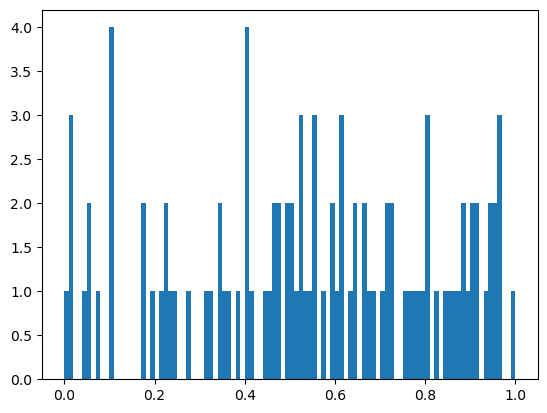

In [68]:
rand_numbers  = get_random_and_plot(generator_u, 100, 100)

In [69]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 94.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


De la misma manera que en el generador anterior, al ser muy pocos los numeros que generamos nuestro test tiene altas chances de dar resultados diferentes segun que tanta "suerte" tengamos al generar los 100 numeros

Probamos el generador con una muestra de 10000 numeros

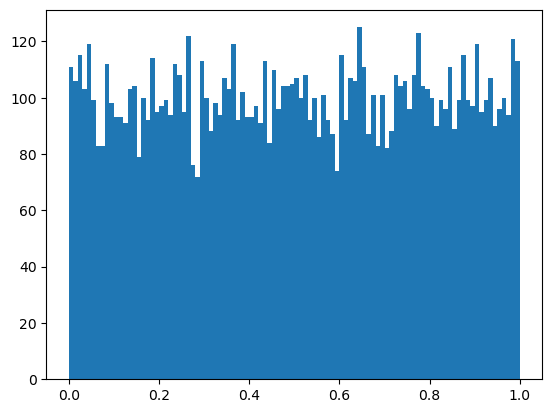

In [70]:
rand_numbers  = get_random_and_plot(generator_u, 10000, 100)

In [71]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 117.52
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

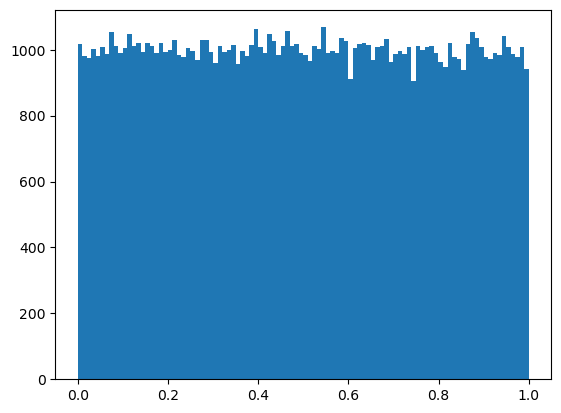

In [72]:
rand_numbers  = get_random_and_plot(generator_u, 100000, 100)

In [73]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 81.5
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


### Test TCL

**H0** : la distribucion **no** es $uniforme (0,m)$, que es equivalente a que la media $μ != (m-0)/2$  
**H1** : la distribucion es $uniforme (0,m)$  

Para el caso del generador base tendremos una distribucion uniforme discreta entre 0 y 2 **32 -1 y para el generador normalizado uns distribucion discreta continua entre 0 y 1.

Por el Teorema Central del Limite, podemos decir que la sumatoria de variables aleatorias de igual media y varianza tiende a una normal. Luego, podemos plantear un test de nivel de significacion asintotico alfa.

$(\sum_{i=1}^{n} t_i - nμ)/ \sqrt{nVAR[X]}$  aproximadamente una normal estandar Z

Entonces podemos plantear un test donde rechazamos h0 en la zona central que acumule probabilidad alfa

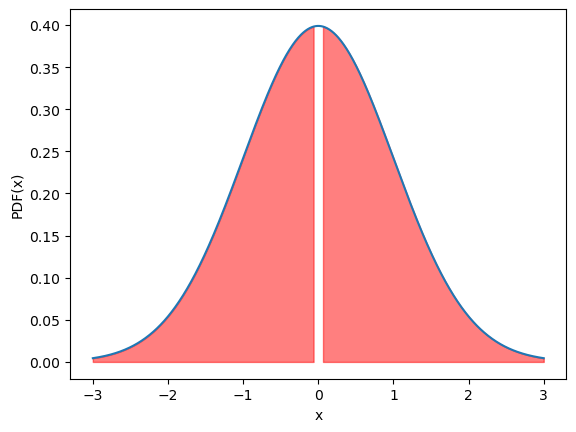

In [74]:
from scipy.stats import norm

# Crear un array de valores x en el rango de -3 a 3
x = np.linspace(-3, 3, 1000)
alpha = 0.05
# Calcular la función de densidad de probabilidad (PDF) de la distribución normal estándar
pdf = np.exp(-0.5*x**2) / np.sqrt(2*np.pi)
# Trama la PDF en un gráfico
plt.plot(x, pdf)

# Marca los cuantiles del 5% y del 95% con un relleno rojo
lower_quantile = norm.ppf((1-alpha)/2)  # cuantil del 5%
upper_quantile = -norm.ppf((1-alpha)/2)  # cuantil del 95%

plt.fill_between(x, pdf, where=(x < lower_quantile), color='red', alpha=0.5)
plt.fill_between(x, pdf, where=(x > upper_quantile), color='red', alpha=0.5)

# Agrega etiquetas al gráfico y muestra el resultado
plt

plt.xlabel('x')
plt.ylabel('PDF(x)')
plt.show()

Es decir que rechazaremos h0 cuando $|z| < q(1-alpha)/2$ que es aproximadamente $$|(\sum_{i=1}^{n} t_i - nμ)/ \sqrt{nVAR[X]}| < q(1-alpha)/2$$

siedo :
+$μ = m/2$ y 
+ var[x] = m^2/12$n

Este test funcionara mejor cuantos mas numeros aleatorios se generen

Creamos un xorshift generator para aplicarte el test

In [75]:
generator = Xorshift_generator(565555555)

In [76]:
def tcl_test_for_uniform_distribution(rand_numbers, max, varianza ,significance_level):
    n = len(rand_numbers)
    numerator = sum(rand_numbers) - n *(max/2)
    denominator = (n*varianza(rand_numbers,max))**1/2
    value = numerator/denominator


    print(n)
    print(numerator)
    print(denominator)
    print(value)
    print(norm.ppf((1-significance_level)/2))
    if (value > norm.ppf((1-significance_level)/2)) and (value < -norm.ppf((1-significance_level)/2)):
        print("Hay suf evidencia para rechazar h0")
    else:
        print("No hay suf evidencia para rechazar h0")
    

In [77]:
def discrete_uniform_var(rand_numbers ,max):
    return (((max+1)**2)-1)/12

In [78]:
def continue_uniform_var(rand_numbers, max):
    return ((max)**2)/12

In [79]:
rand_numbers = generator.get_n_rand(1)
tcl_test_for_uniform_distribution(rand_numbers, 2**32-1, discrete_uniform_var, 0.05 )
print(rand_numbers[:5])

1
-1545505512.5
7.686143364045646e+17
-2.0107685210889875e-09
-0.06270677794321385
Hay suf evidencia para rechazar h0
[601978135]


In [80]:
generator_u = Uniform_generator(3456789654)

In [81]:
rand_numbers = generator_u.get_n_rand(10000)
tcl_test_for_uniform_distribution(rand_numbers, 1, continue_uniform_var, 0.05 )
print(rand_numbers[:5])


10000
-19.354753421461282
416.66666666666663
-0.04645140821150708
-0.06270677794321385
Hay suf evidencia para rechazar h0
[0.5595704944710178, 0.5903879584722193, 0.3248876885801758, 0.09141610215683843, 0.6621731574791887]


### Test Kolmogorov - Smirnov
https://www.statology.org/kolmogorov-smirnov-test-python/ (de donde saque, lo pego aca para no perder el link)

**H0** : La distribucion es uniforme discreta  
**H1** : La distribucion **no** es uniforme discreta

Nuestra hipotesis nula es que el arreglo 'data' (generado por nuestro RNG) sigue una distribucion uniforme.
Si el p-value es menor que el nivel de significacion (por default = 0.05) entonces se rechaza la hipotesis nula y decimos que hay suficiente evidencia para decir que
la muestra de numeros en el arreglo 'data' no viene de una distribucion uniforme.
Empezamos testeando para 100 elementos.

In [82]:
import random
generator = Xorshift_generator(695619357)
generator_u = Uniform_generator(56789876)

In [83]:
def test_kolmogorov_smirnov(distribution, max, quantity, func):
    data = []
    for i in range(quantity):
        data.append(func())
    p_value = kstest(data, distribution, args=(0, max)).pvalue

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Los datos no siguen una distribucion uniforme.')
    print(f'El p-valor es: {p_value}')
    plt.hist(data, bins=100)
    plt.show()


No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.5416340875713932


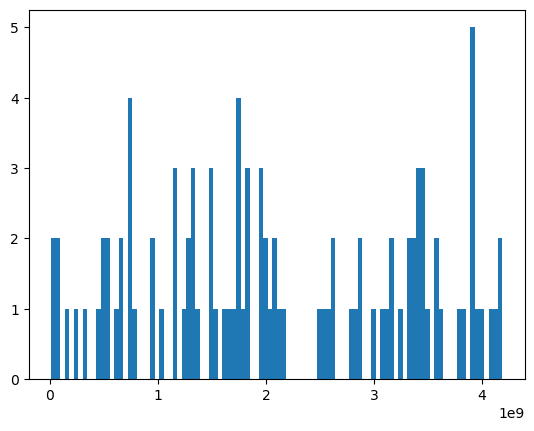

In [84]:
test_kolmogorov_smirnov('randint', (2**32)-1, 100, generator.rand)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.7417153553911521


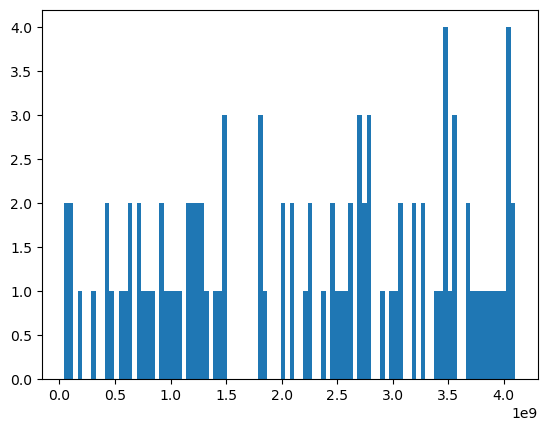

In [85]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 100, generator.rand)

Seguimos con 10000 elementos.

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9676165972598199


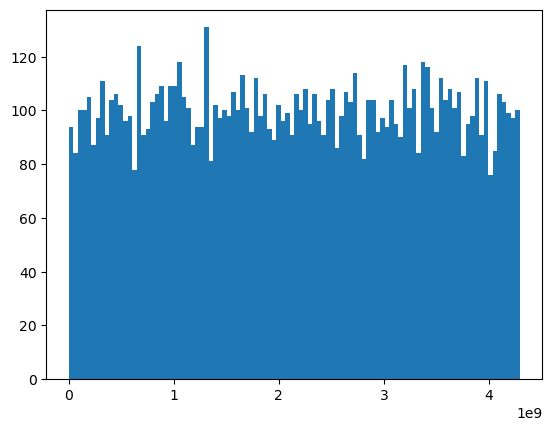

In [86]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 10000, generator.rand)

Finalizamos el testeo con Kolgomorov - Smirnov del RNG con 100000 elementos.

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9942496320623575


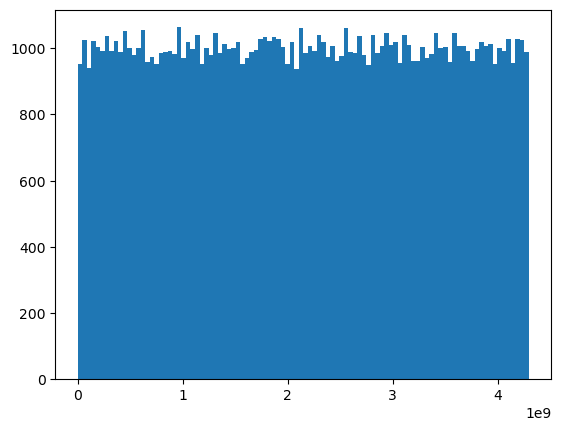

In [87]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 100000, generator.rand)

Ahora testemos con las mismas cantidades de elementos pero para el RNG normalizado. Empezamos con 100 elementos.

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.8012532872899683


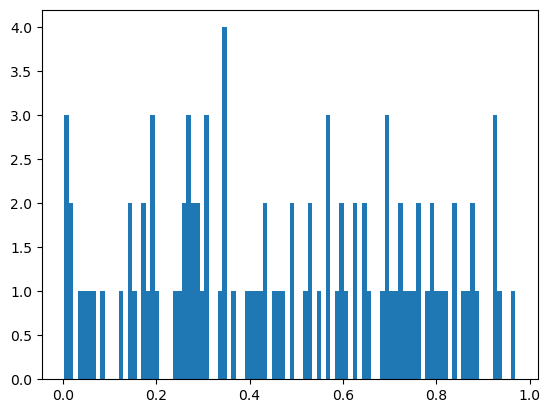

In [88]:
test_kolmogorov_smirnov('uniform', 1, 100, generator_u.rand)

Seguimos con 10000

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9802847146323567


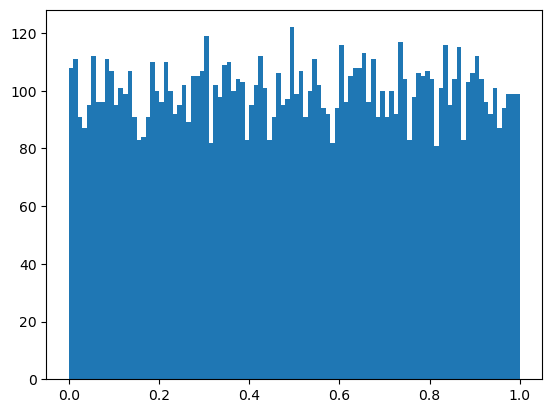

In [89]:
test_kolmogorov_smirnov('uniform', 1, 10000, generator_u.rand)

Finalizamos con 100000

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9436486493216023


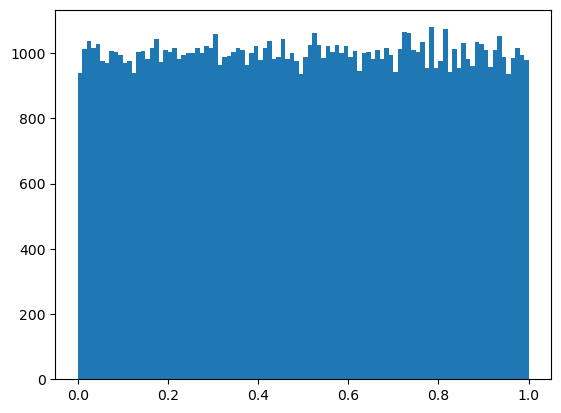

In [90]:
test_kolmogorov_smirnov('uniform', 1, 100000, generator_u.rand)

Despues del análisis de los resultados de los test de _Komolgorov Smirnov_ con las distintas muestras, los resultados tendieron a ser los siguientes:  
  
En la mayoria de las corridas, el test arroja que no tenemos evidencia suficiente para rechazar **H0**, es decir, no hay evidencia para afirmar que la distribucion **no** es uniforme. Esto lo podemos ver también con el resultado del p-valor: el significado que tiene es la probabilidad de cometer un error de tipo 1 (rechazar **H0** cuando es verdadera), cuando el p-valor toma valores muy altos nos indica que hay una probabilidad muy alta de que **H0** sea verdadera si elegimos rechazarla.  
  
Sin embargo, el resultado del test es fluctuante (por ejemplo, en corridas consecutivas los p-valores iban desde cerca de 0.9 a casi 0.01, lo cual nos confundía bastante). Primero creimos que el error estaba en nuestro generador, así que probamos con el generador de numeros aleatorios de python _randint_. Como vimos que también fluctuaba, pensamos que era un error al testear.   
  
Luego de pensarlo y debatirlo, llegamos a una conclusion razonable: El p-valor varía porque la muestra varía (generamos nuevos numeros aleatorios en cada corrida del test), y como el test de hipótesis depende casi exclusivamente de la muestra, eso explica las eventuales variaciones que haya. Que a veces el p-valor sea lo suficientemente chico como para rechazar **H0** nos dice que en esa corrida se genero una muestra que podia contener sesgos y acumulaciones de ciertos numeros en cierto intervalo, lo que hacia que se incline la balanza a favor de decidir que el generador no fuese "uniforme". Este caso puede ocurrir con una probabilidad baja, pero esta no es nula, asi que puede pasar.  

## Ejercicio 3

*Utilizando el generador implementado en el ejercicio 1:  
● Implementar un método para generar variables aleatorias con distribución Normal con media 25, y
desvío estándar 3  
● Graficar la distribución que siguen los números pseudoaleatorios generados.  
● Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalué los resultados para distintos tamaños de muestra).*

Para obtener muestras de una normal, no podemos usar el metodo de la transformada inversa, ya que su funcion de densidad no es invertible. Es por eso que utilizaremos el metodo de aceptacion y rechazo.

Para generar numeros que sigan una distribucion normal vamos a elegir el método de Aceptación y Rechazo 2, partiendo con los numeros producidos por nuestro generador. Lo que vamos a hacer es generamos una distribucion normal estándar, luego podemos pasar de esa normal a una normal con media 25 y desvio estandar 3

Sin embargo, si intentemos usar ya sea el generador de numeros enteros entre 0 hasta 2**32-1 o el generador de numeros uniforme entre 0 y 1, no podremos generar valores que no pertescan al dominio de estos generadores. Es por esto que antes de obtener un generador de valores normales, obtendremos un generador que genere muestras que se distribuyan de manera exponencial, utilizando el metodo de la transformada inversa. 

In [102]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        return log(r/self.parameter)/(-1*self.parameter)
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

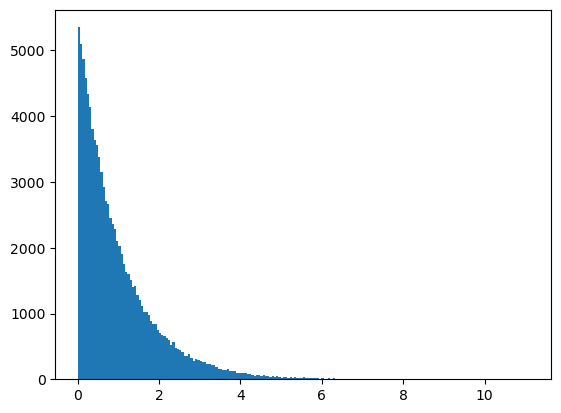

In [103]:
generator_exp = Exp_generator(987654323)
rand_numbers = get_random_and_plot(generator_exp, 100000, 200)

Si bien el dominio de la exponencial es solo do 0 a inf mientras que la normal va de -inf a inf, podemos utilizar un truco, donde generamos la mitad positiva de la campana de gaus, y luego la multiplicamos por 1 o -1 con probabilidad de 0.5, generando asi toda la campana. 

$f_N(n) = \frac{1}{\sqrt{(2*pi)}} * e^{\frac{-n^2}{2}}  $  
$f_X(x) = \frac{2}{\sqrt{(2*pi)}} * e^{\frac{-x^2}{2}} * \mathbf{1} \{ x>0 \}$  

Vamos a generar los numeros de la normal, a partir del generador exponencial, es decir que podemos llamar Y a una VA con distribucion exp, la cual sabemos generar.

In [165]:
def fx_divided_by_fy(x):
    if x < 0:
        return 0
    return (2 / (2 * pi) ** (1 / 2)) * e ** (x -(x ** 2) / 2)

class Normal_distribution_generator:
    
    def __init__(self, seed, mean=0, variance=1):
        self.mean = mean
        self.std_deviation = variance**(1/2)
        self.generator_exp = Exp_generator(seed)
        self.uniform_generator = Uniform_generator(seed + 100) #para que no haya relacion entre los numeros generados entre los generadores usamos semillas distintas
        self.c = fx_divided_by_fy(1) #el maximo se alcanza en 1
        
    def get_parameters(self):
        return self.mean, self.std_deviation

    def rand(self):
        encontrado = False
        while not encontrado:
            r = self.uniform_generator.rand()
            r_exp = self.generator_exp.rand()
            if r < fx_divided_by_fy(r_exp)/self.c:
                encontrado  = r_exp

        r2 = self.uniform_generator.rand()
        
        if r2 < 0.5:
            encontrado = -1 * r_exp
                    
        return self.std_deviation * encontrado + self.mean
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

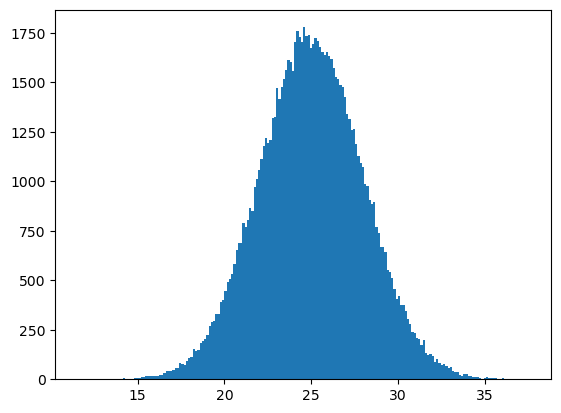

In [166]:
normal_generator = Normal_distribution_generator(987654323, 25, 9)
normal_rand_numbers = get_random_and_plot(normal_generator, 100000, 200)

#### Test Kolmogorov-Smirnov

In [169]:
def kolmogorov_smirnov_normal_test(quantity, normal_generator):
    normal_rand_numbers = []
    for _ in range(quantity):
        normal_rand_numbers.append(normal_generator.rand())
    p_value = kstest(normal_rand_numbers, 'norm', args=normal_generator.get_parameters()).pvalue

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Los datos no siguen una distribucion normal.')

    print(f'El p-valor es: {p_value}')

Primero instanciamos el generador de numeros normales

In [167]:
normal_generator = Normal_distribution_generator(5555555)

Luego realizamos el test de Kolmogorov-Smirnov para distintos tamaños de muestras: 100, 10000 y 100000 elementos

In [172]:
kolmogorov_smirnov_normal_test(100, normal_generator)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.2018183992516833


In [173]:
kolmogorov_smirnov_normal_test(10000, normal_generator)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.7720235137425603


In [174]:
kolmogorov_smirnov_normal_test(100000, normal_generator)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.6922398262665426


Testearemos nuestro nuevo generador con el test Shapiro-Wilk en donde la hipotesis nula sera que la muestra obtenida por nuestro generador sigue una distribucion normal.

In [126]:
def shapiro_test(quantity):
    data = normal_generator.get_n_rand(quantity)
    
    w, p_value = shapiro(data)

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Data no sigue una distribucion uniforme.')
    print(f'El p-valor es: {p_value}')

In [144]:
shapiro_test(100)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.6534752249717712


In [132]:
shapiro_test(10000)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.5183401107788086


In [122]:
shapiro_test(100000)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9972816109657288


**Conclusion**  
En todos los casos vemos que no hay evidencia para rechazar la hipotesis nula, por lo que la muestra puede provenir de una distribucion normal. Al igual que para el test de la uniforme, el p-valor va variando según la muestra y vimos que, por ejemplo para el caso de 100 numeros, algunas pocas corridas resultaban en rechazar **H0**, lo cual se explica dado que la cantidad pequeña de muestras puede hacer que el resultado del test fluctue bastante.

## Ejercicio 4

Kmeans

In [175]:
import pandas as pd

In [180]:
clusters = 5
dataset = pd.read_csv('dataset_kmeans_tema2.csv')

def kmeans(clusters):
    uniform_generator = Uniform_generator(23232323)
    centroides = []
    max_x = dataset['x'].max()
    max_y = dataset['y'].min()

    
    



SyntaxError: invalid syntax (3335867284.py, line 6)

In [179]:
dataset

NameError: name 'dataset' is not defined